In [1]:
import platform
import os
import sys
import pandas as pd
import numpy.random as rd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib import rcParams
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'Osaka'

In [2]:
import rpy2
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from rpy2.rinterface import R_VERSION_BUILD
#from rpy2.robjects.functions import SignatureTranslatedFunction

from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [3]:
print("env:", platform.system())
print("os.name:", os.name)
print("python ver:", platform.python_version())
print("python env:", sys.version)
print("rpy2 version:", rpy2.__version__)
print("R_VERSION_BUILD:", R_VERSION_BUILD)



env: Darwin
os.name: posix
python ver: 3.5.2
python env: 3.5.2 |Anaconda 4.3.0 (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
rpy2 version: 2.8.2
R_VERSION_BUILD: ('3', '3.1', '', 70800)


# データ作成

In [4]:
rd.seed(71)

T = 500
v_sd = 20 # 観測誤差の標準偏差
i_sd = 10 # interceptの標準偏差
a10 = 10
e_sd1 = .5 # 回帰係数1の変動の標準偏差
a20 = 20
e_sd2 = .8 # 回帰係数1の変動の標準偏差

# 時変回帰係数２つ
e1 = np.random.normal(0, e_sd1, size=T)
a1 = e1.cumsum() + a10
e2 = np.random.normal(0, e_sd2, size=T)
a2 = e2.cumsum() + a20

# intercept
intercept = np.cumsum(np.random.normal(0, i_sd, size=T))

# 説明変数
x1 = rd.normal(10, 10, size=T)
x2 = rd.normal(10, 10, size=T)

# 被説明変数
v = np.random.normal(0, v_sd, size=T) # 観測誤差
y = intercept + a1*x1 + a2*x2 + v
y_noerror = intercept + a1*x1 + a2*x2  # 観測誤差がなかった時の　y

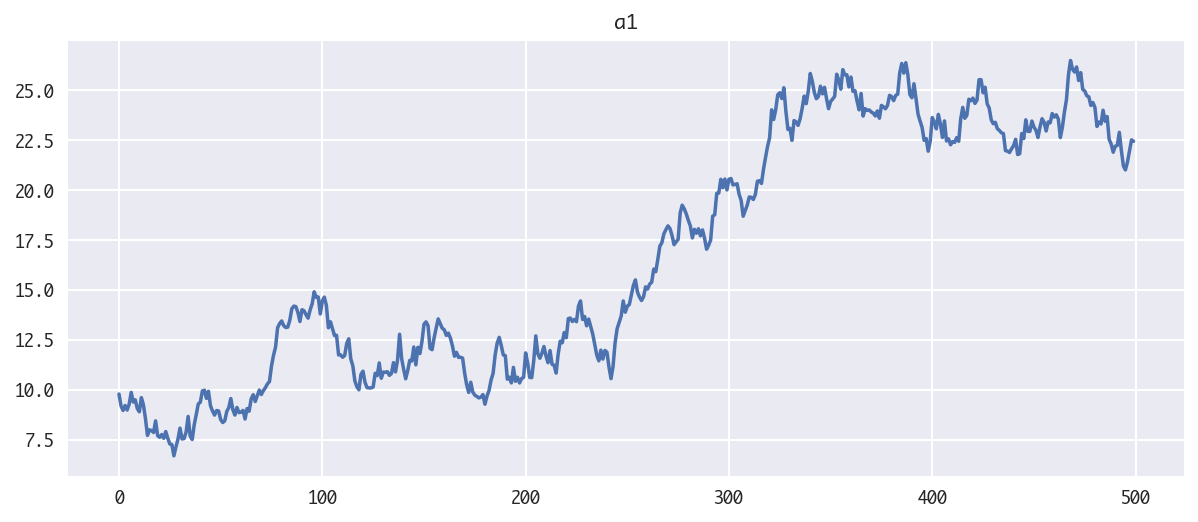

In [5]:
# 時変回帰係数1のプロット
plt.figure(figsize=(10,4))
plt.plot(a1)
plt.title("a1")

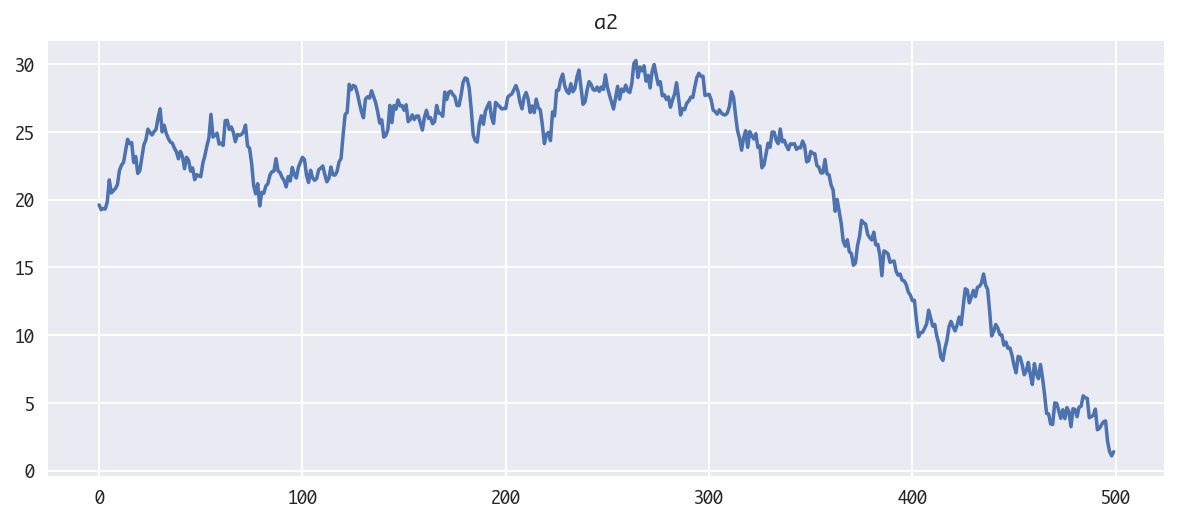

In [6]:
# 時変回帰係数2のプロット
plt.figure(figsize=(10,4))
plt.plot(a2)
plt.title("a2")

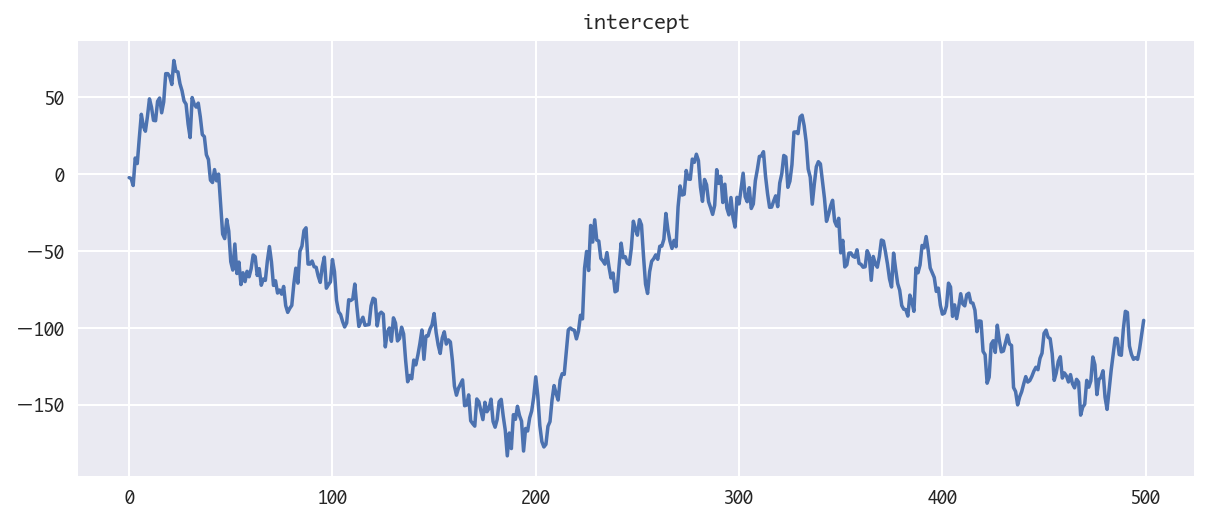

In [7]:
# interceptをプロット
plt.figure(figsize=(10,4))
plt.plot(intercept)
plt.title("intercept")

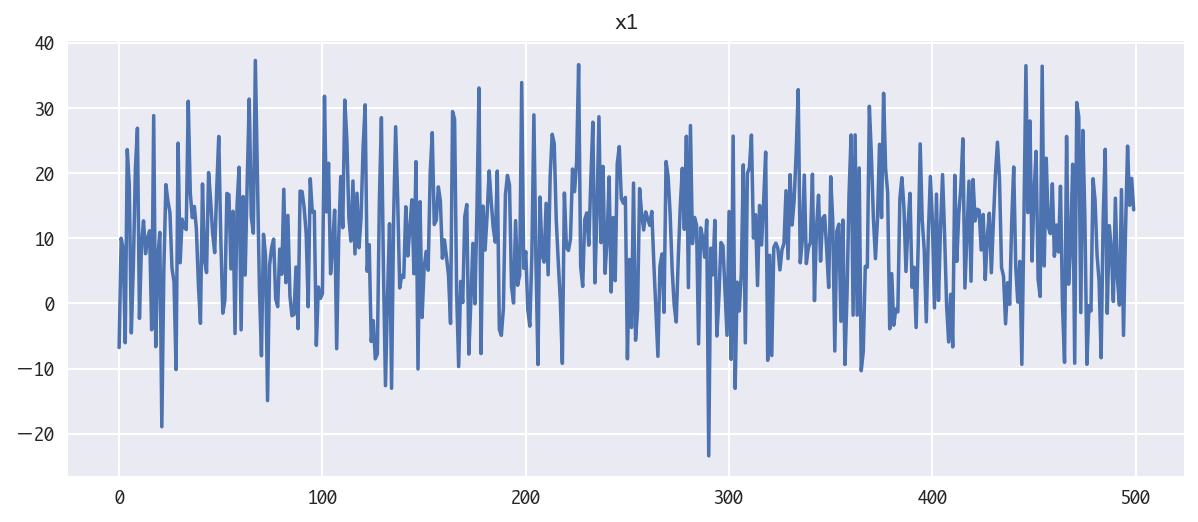

In [8]:
# 説明変数をプロット
plt.figure(figsize=(10,4))
plt.plot(x1)
plt.title("x1")

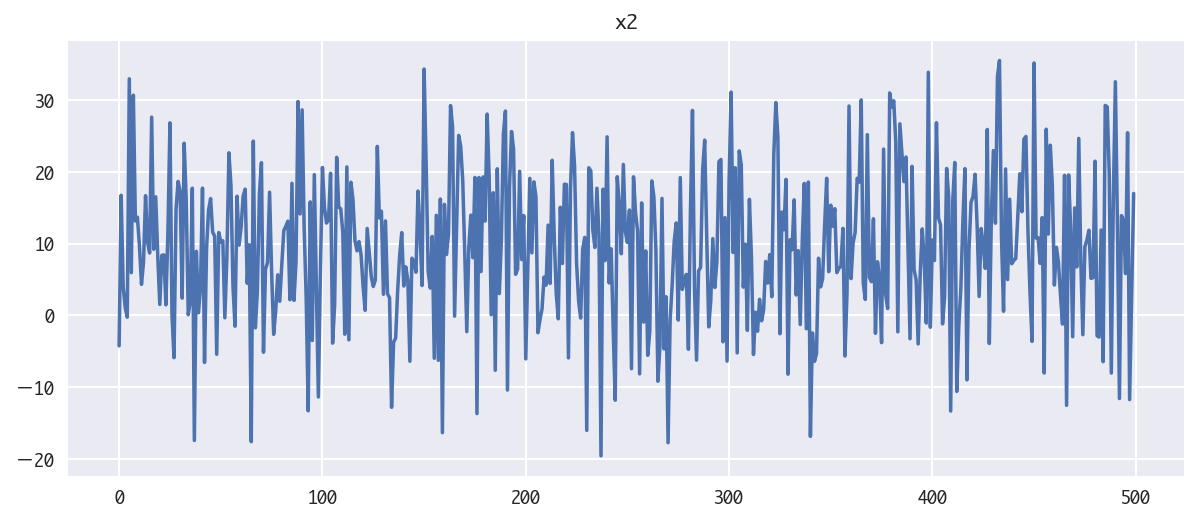

In [9]:
# 説明変数をプロット
plt.figure(figsize=(10,4))
plt.plot(x2)
plt.title("x2")

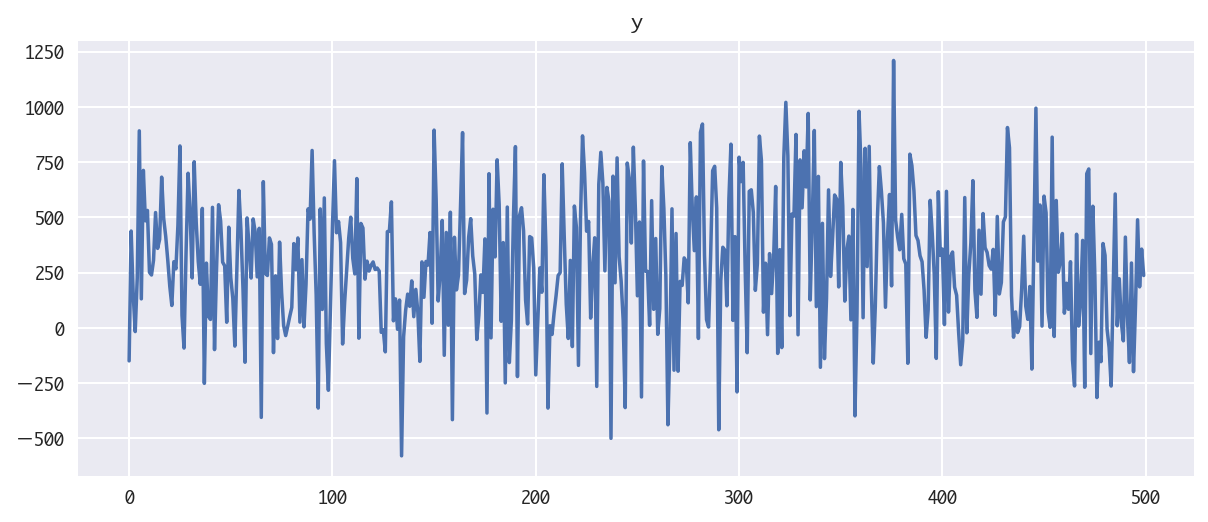

In [10]:
# 観測値をプロット
plt.figure(figsize=(10,4))
plt.plot(y)
plt.title("y")

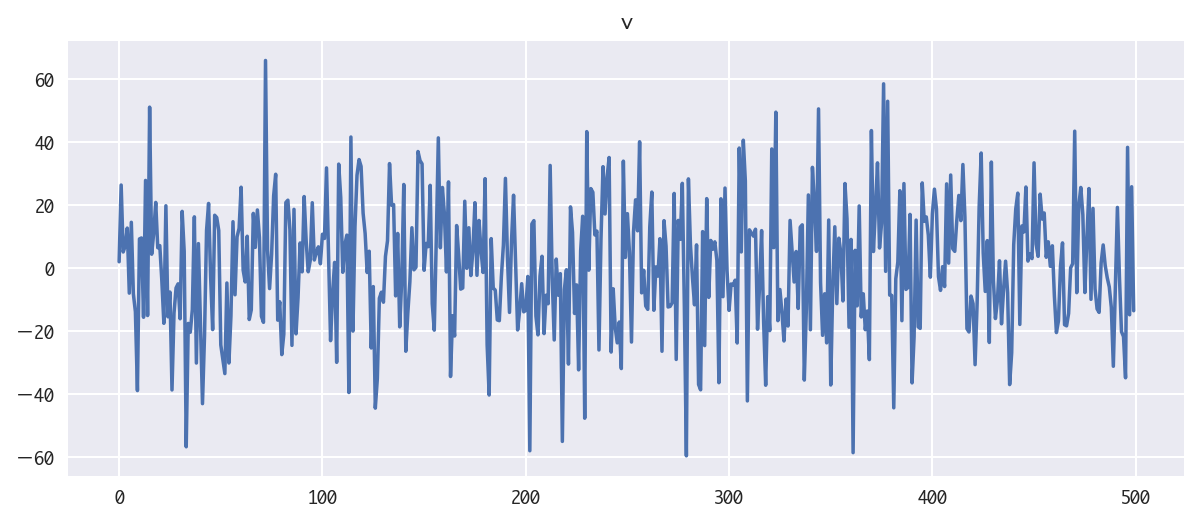

In [11]:
# 観測誤差のプロット
plt.figure(figsize=(10,4))
plt.plot(v)
plt.title("v")

In [12]:
df = pd.DataFrame({"x1":x1, "x2":x2, "y":y, "a1":a1,  "a2":a2, "intercept":intercept})
df.head()

,a1,a2,intercept,x1,x2,y
0,9.784698,19.610076,-2.215152,-6.768232,-4.238996,-149.547649
1,9.187734,19.249373,-2.804606,10.001302,16.760184,438.058268
2,8.965585,19.348741,-7.342012,8.388453,4.014684,150.659873
3,9.210291,19.297976,10.552154,-6.030999,1.090963,-16.883775
4,8.984512,19.822178,6.933788,23.608283,-0.249615,226.788912


In [13]:
df.to_csv("data.csv")

# DLM


In [14]:
def get_method(result, method_name):
    """Rの関数の戻り値で取得したオブジェクトの関数を取り出す
    result: Rの関数の戻り値で取得したオブジェクト
    method_name: 取り出したいメソッドの名称
    """
    for i in result.items():
        if i[0] == method_name:
            return i[1]
    assert False

In [15]:
def show_result(result):
    """Rの関数の戻り値で取得したオブジェクトの関数を取り出す
    result: Rの関数の戻り値で取得したオブジェクト
    method_name: 取り出したいメソッドの名称
    """
    for i in result.items():
        print(i[0], i[1], )

In [16]:
dlm = importr("dlm")

In [17]:
buildDlmReg = lambda theta: dlm.dlmModReg(
    X=df[["x1", "x2"]], 
    dV=np.exp(theta[0]), 
    dW=[np.exp(theta[1]), np.exp(theta[2]), np.exp(theta[3])]
  )

In [18]:
# 2段階で最尤推定を行う
%time parm = dlm.dlmMLE(y, parm=[2, 1, 1, 1], build=buildDlmReg, method="L-BFGS-B") #Nelder-Mead")
par = np.array(get_method(parm, "par"))
print("par:", par)
%time fitDlmReg = dlm.dlmMLE(y, parm=par, build=buildDlmReg, method="SANN")#SANN", "L-BFGS-B"

CPU times: user 1.45 s, sys: 10.6 ms, total: 1.46 s
Wall time: 1.47 s
par: [ 5.99988463  4.57242133 -1.65722425 -0.92329885]
CPU times: user 1min 9s, sys: 459 ms, total: 1min 9s
Wall time: 1min 10s


In [19]:
show_result(fitDlmReg)

par [1]  5.9998846  4.5724213 -1.6572242 -0.9232988

value [1] 2017.984

counts function gradient 
   10000       NA 

convergence [1] 0

message NULL


In [20]:
# 収束確認(0ならOK)
convergence = get_method(fitDlmReg, "convergence")
print("convergence:", convergence[0])

convergence: 0


In [21]:
par = np.asanyarray(get_method(fitDlmReg, "par"))
modDlmReg = buildDlmReg(par)

In [22]:
show_result(modDlmReg)

m0 [1] 0 0 0

C0       [,1]  [,2]  [,3]
[1,] 1e+07 0e+00 0e+00
[2,] 0e+00 1e+07 0e+00
[3,] 0e+00 0e+00 1e+07

FF      [,1] [,2] [,3]
[1,]    1    1    1

V          [,1]
[1,] 403.3823

GG      [,1] [,2] [,3]
[1,]    1    0    0
[2,]    0    1    0
[3,]    0    0    1

W          [,1]      [,2]      [,3]
[1,] 96.77816 0.0000000 0.0000000
[2,]  0.00000 0.1906675 0.0000000
[3,]  0.00000 0.0000000 0.3972066

JFF      [,1] [,2] [,3]
[1,]    0    1    2

JV NULL
JGG NULL
JW NULL
X               x1           x2
0    -6.76823189  -4.23899602
1    10.00130184  16.76018401
2     8.38845308   4.01468447
3    -6.03099922   1.09096303
4    23.60828251  -0.24961542
5    18.10697671  33.00349459
6    -4.52336991   5.96442252
7     5.84491720  30.72054608
8    20.64737133  13.16869333
9    26.88502683  13.70743334
10   -2.29518983   9.64197075
11    9.18174645   4.34043999
12   12.67884268   7.44107955
13    7.63960791  16.70152864
14   10.04770874  10.21502698
15   11.15284937   8.71678976
16   -4.03

In [23]:
estimated_sd = np.sqrt(np.exp(np.array(get_method(fitDlmReg, "par"))))

pd.DataFrame({"estimated_sd":estimated_sd, "sd":[v_sd, i_sd, e_sd1, e_sd2]})

,estimated_sd,sd
0,20.084378,20.0
1,9.837589,10.0
2,0.436655,0.5
3,0.630243,0.8


In [24]:
# カルマンフィルタ
filterDlmReg = dlm.dlmFilter(y, modDlmReg)

# スムージング
smoothDlmReg = dlm.dlmSmooth(filterDlmReg)

In [25]:
show_result(filterDlmReg)

y   [1] -149.547649  438.058268  150.659873  -16.883775  226.788912  891.606660
  [7]  131.115890  712.671765  484.227095  531.467792  251.441602  239.193877
 [13]  305.957232  521.780781  359.641374  400.102738  682.013463  494.534959
 [19]  413.526812  307.023517  187.629319  101.270097  299.314514  267.061354
 [25]  464.736471  823.230507   56.937922  -91.485504  340.523602  699.624693
 [31]  520.777612  225.839397  751.681475  475.905072  300.226831  197.204213
 [37]  540.483731 -251.315465  292.952720   52.308082   38.028036  545.437391
 [43]  -98.490543  268.886904  557.199495  483.849442  297.216755  280.360249
 [49]   25.347337  455.395171  226.657906  132.566023  -82.600767  275.639333
 [55]  621.771968  440.935260  177.465290 -155.763354  497.445900  367.483651
 [61]  225.435226  492.778074  434.047549  230.797751  450.422636 -405.312548
 [67]  661.610025  246.391883  237.011898  407.001301  378.068838 -112.184249
 [73]  235.217945  -48.318379  387.984975  159.953413   10.277

In [26]:
show_result(smoothDlmReg)

s                [,1]      [,2]      [,3]
  [1,]    4.4090370  8.300657 21.131186
  [2,]    4.4090796  8.300657 21.131187
  [3,]    6.3766651  8.274421 21.096956
  [4,]    9.4628028  8.270225 21.139670
  [5,]   15.6789971  8.317758 21.233958
  [6,]   23.2300505  8.349430 21.334224
  [7,]   27.9576433  8.249778 21.437382
  [8,]   31.0629311  8.092253 21.320789
  [9,]   31.8911647  7.955020 21.148454
 [10,]   36.4160099  7.860355 21.442211
 [11,]   40.1852345  7.734952 21.695129
 [12,]   47.3268195  7.788176 22.137773
 [13,]   52.4199081  7.850662 22.499351
 [14,]   53.4262306  7.839221 22.788126
 [15,]   58.3742653  7.926240 23.197282
 [16,]   59.6220447  7.957567 23.352792
 [17,]   65.3047792  8.076686 23.694241
 [18,]   61.8269689  7.994522 23.707959
 [19,]   59.1479536  7.906005 23.812364
 [20,]   59.3991045  7.983852 24.027758
 [21,]   57.3039516  8.092356 24.083923
 [22,]   56.6347983  8.220217 24.188668
 [23,]   54.9266799  8.325781 24.286868
 [24,]   53.1717808  8.433088 24.38345

In [27]:
filtered_a = np.array(get_method(filterDlmReg, "a"))
smoothed_a = np.array(get_method(smoothDlmReg, "s"))

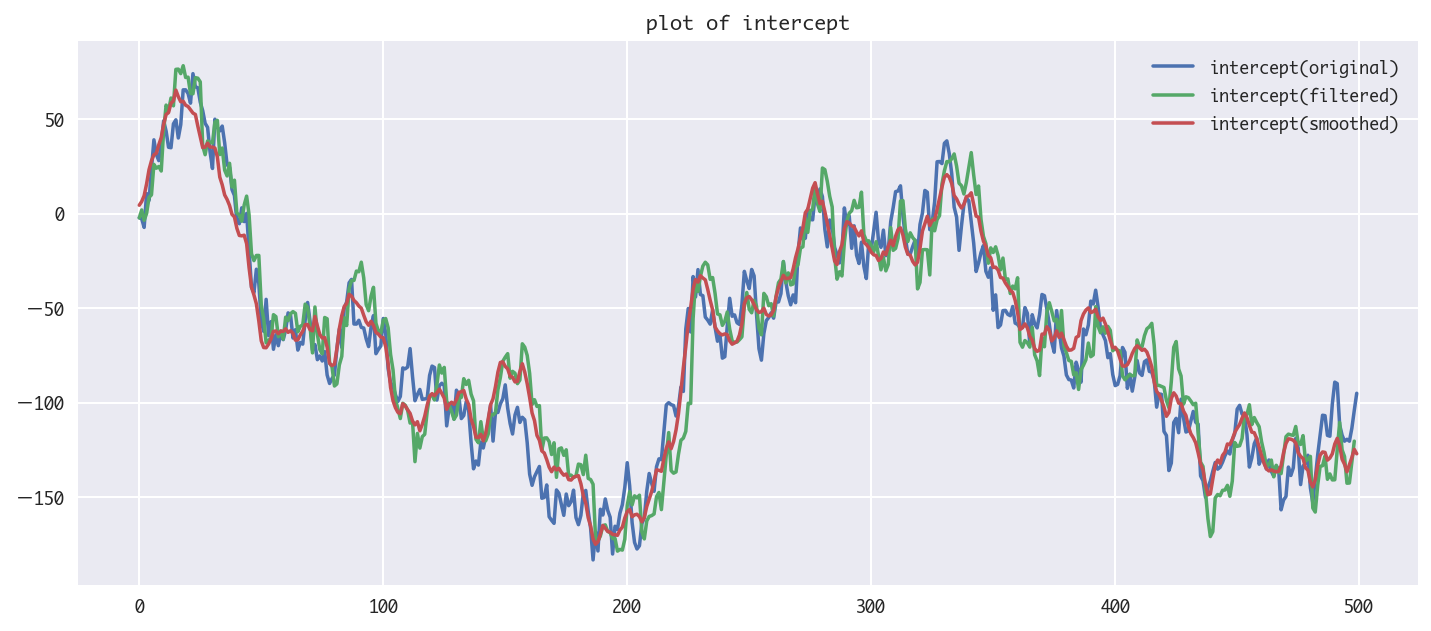

In [28]:
plt.figure(figsize=(12,5))
plt.plot(df.intercept, label="intercept(original)")
plt.plot(filtered_a[1:,0], label="intercept(filtered)")
plt.plot(smoothed_a[1:,0], label="intercept(smoothed)")
plt.legend(loc="best")
plt.title("plot of intercept")

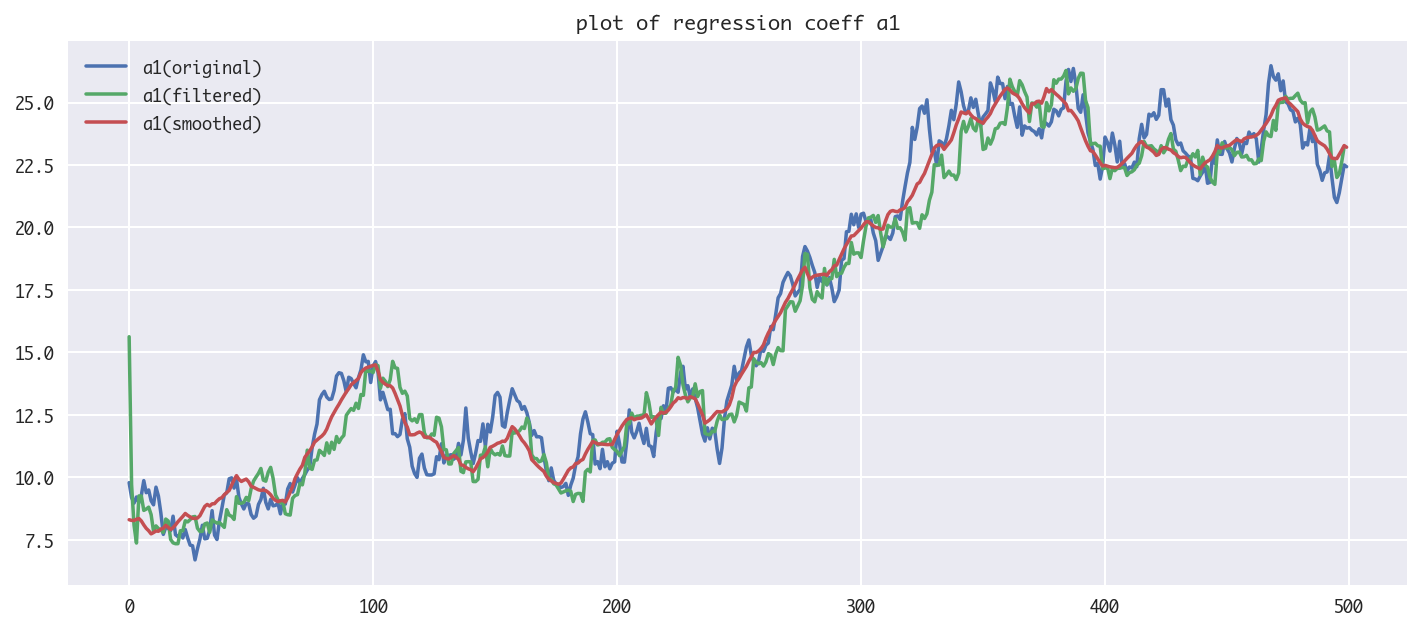

In [29]:
plt.figure(figsize=(12,5))
plt.plot(df.a1, label="a1(original)")
plt.plot(filtered_a[1:,1], label="a1(filtered)")
plt.plot(smoothed_a[1:,1], label="a1(smoothed)")
plt.legend(loc="best")
plt.title("plot of regression coeff a1")

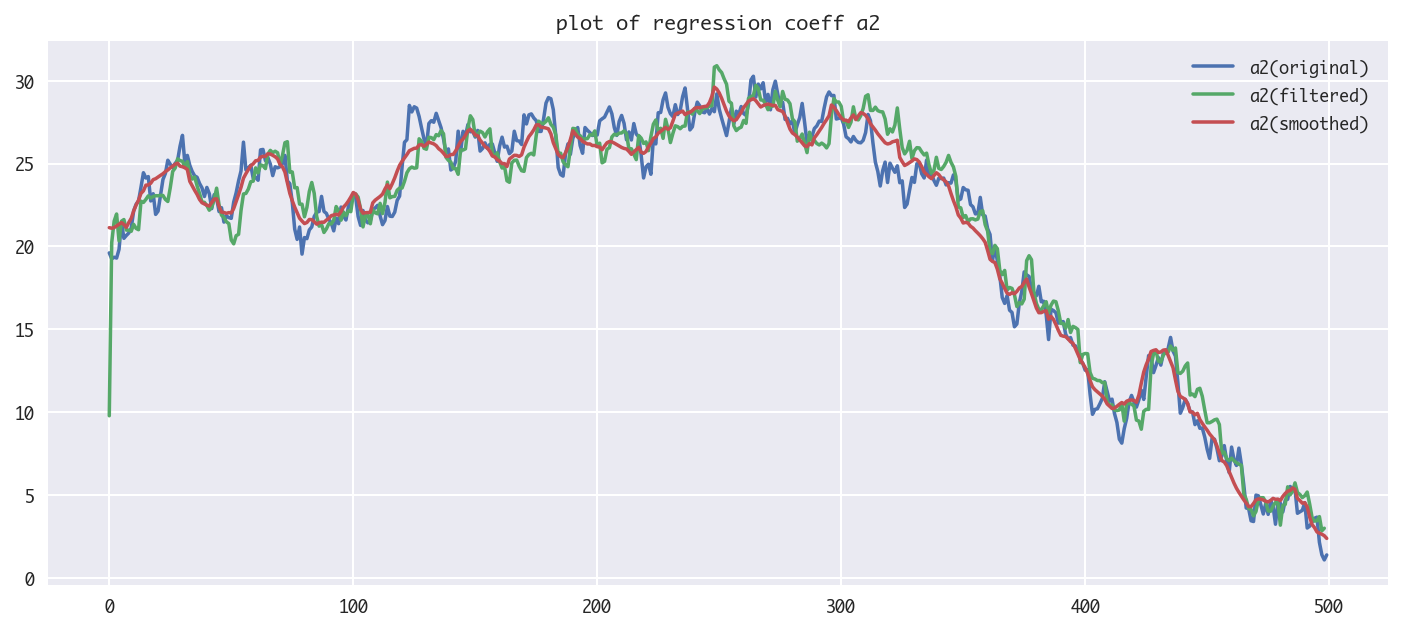

In [30]:
plt.figure(figsize=(12,5))
plt.plot(df.a2, label="a2(original)")
plt.plot(filtered_a[1:,2], label="a2(filtered)")
plt.plot(smoothed_a[1:,2], label="a2(smoothed)")
plt.legend(loc="best")
plt.title("plot of regression coeff a2")

In [31]:
estimatedLevel = smoothed_a[1:,0] + df.x1*smoothed_a[1:,1] + df.x2*smoothed_a[1:,2]


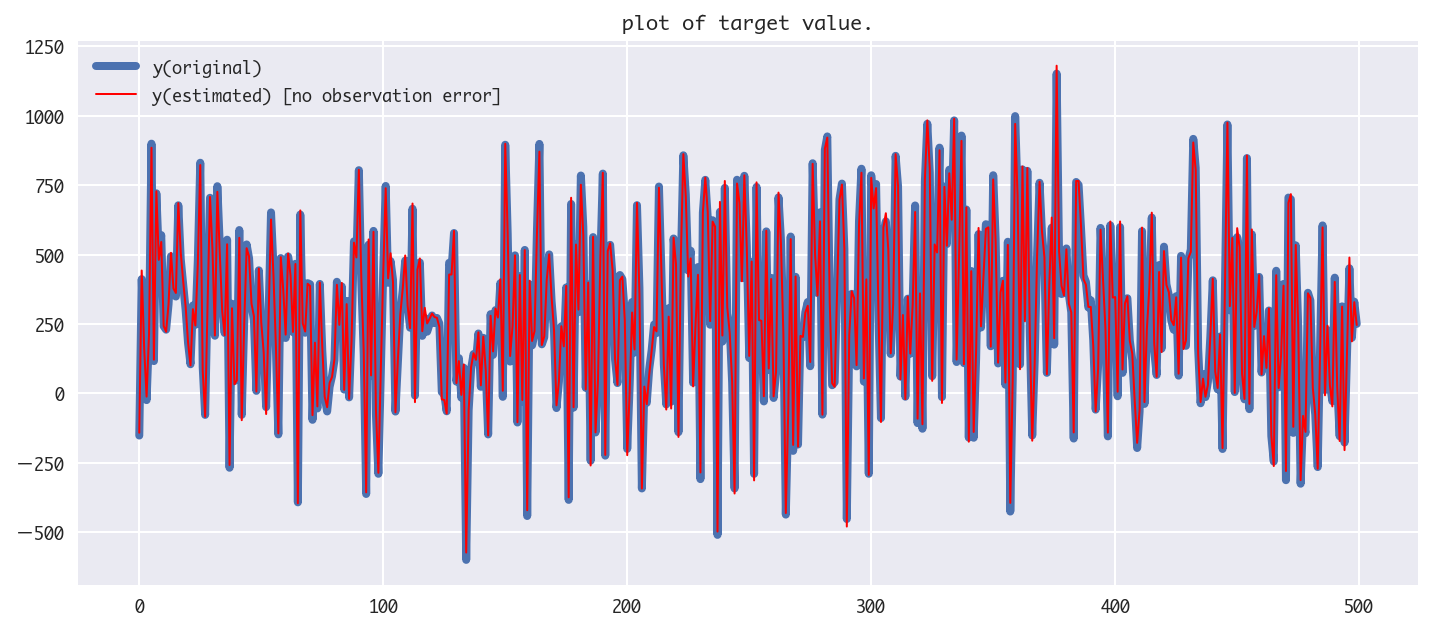

In [32]:
plt.figure(figsize=(12,5))
plt.plot(y_noerror, lw=4, label="y(original)")
plt.plot(estimatedLevel, "r", lw=1, label="y(estimated) [no observation error]")
plt.legend(loc="best")
plt.title("plot of target value.")